In [1]:
import tensorflow as tf

'2.3.1'

In [24]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [25]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182083584/182082353 [==============================] - 9s 0us/step


In [26]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']


In [27]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

TypeError: len is not well defined for symbolic Tensors. (RandomShuffle:0) Please call `x.shape` rather than `len(x)` for shape information.

In [ ]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

In [13]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [14]:

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

In [15]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

NameError: name 'train_files' is not defined

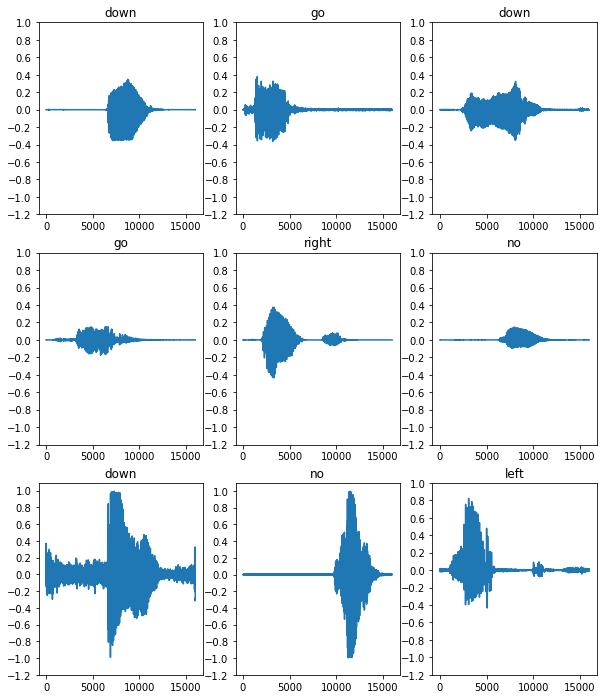

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [45]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(equal_length, frame_length=30, frame_step=20)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [46]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spectrogram shape: (799, 17)
Audio playback


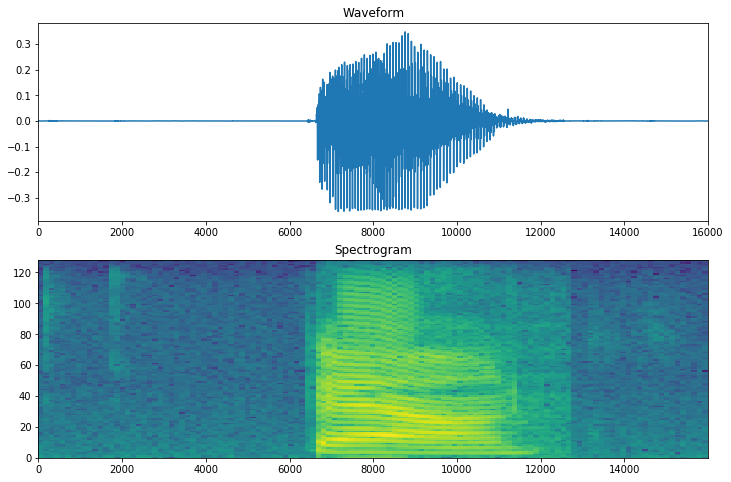

In [21]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [22]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [23]:

spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

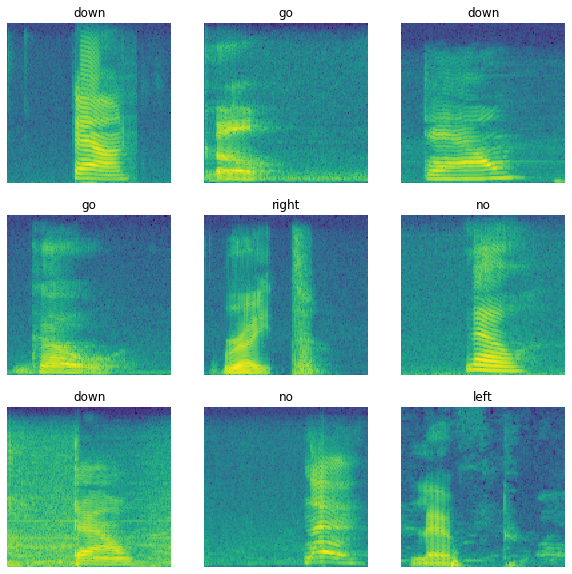

In [24]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

In [25]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [26]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [27]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [28]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [47]:
input_shape

TensorShape([124, 129, 1])

In [29]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

Epoch 1/10
100/100 [==============================] - 10s 99ms/step - loss: 1.7605 - accuracy: 0.3616 - val_loss: 1.3115 - val_accuracy: 0.5813
Epoch 2/10
100/100 [==============================] - 6s 64ms/step - loss: 1.2079 - accuracy: 0.5673 - val_loss: 0.9188 - val_accuracy: 0.7013
Epoch 3/10
100/100 [==============================] - 6s 62ms/step - loss: 0.9377 - accuracy: 0.6572 - val_loss: 0.7912 - val_accuracy: 0.7475
Epoch 4/10
100/100 [==============================] - 6s 65ms/step - loss: 0.7960 - accuracy: 0.7145 - val_loss: 0.6983 - val_accuracy: 0.7625
Epoch 5/10
100/100 [==============================] - 6s 64ms/step - loss: 0.6724 - accuracy: 0.7572 - val_loss: 0.6149 - val_accuracy: 0.7950
Epoch 6/10
100/100 [==============================] - 6s 62ms/step - loss: 0.5889 - accuracy: 0.7859 - val_loss: 0.6166 - val_accuracy: 0.7862
Epoch 7/10
100/100 [==============================] - 6s 63ms/step - loss: 0.5406 - accuracy: 0.8048 - val_loss: 0.5525 - val_accuracy: 0.817

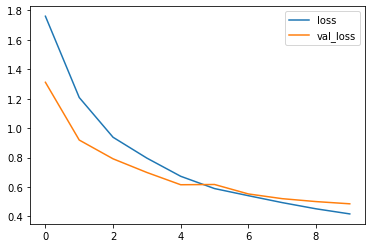

In [32]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [33]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [34]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Test set accuracy: 84%


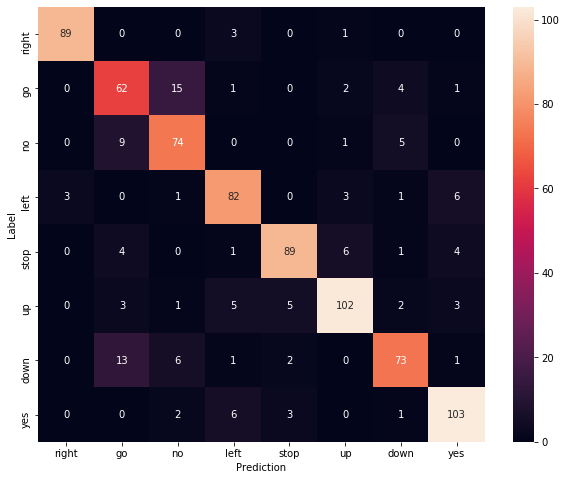

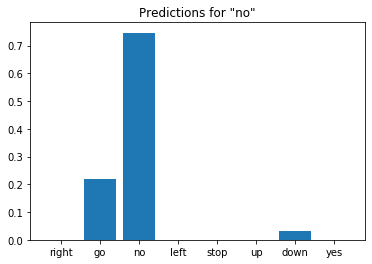

In [36]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import hashlib
import math
import os.path
import random
import re
import sys
import tarfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from tensorflow.python.ops import gen_audio_ops as audio_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.platform import gfile
from tensorflow.python.util import compat



In [2]:
# work, try building with bazel instead of running the Python script directly.
try:
  from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op  # pylint:disable=g-import-not-at-top
except ImportError:
  frontend_op = None

In [50]:
frontend_op

<module 'tensorflow.lite.experimental.microfrontend.python.ops.audio_microfrontend_op' from '/home/aml/anaconda3/envs/saad3.6/lib/python3.6/site-packages/tensorflow/lite/experimental/microfrontend/python/ops/audio_microfrontend_op.py'>

In [3]:
import sys
# We add this path so we can import the speech processing modules
import input_data
import models
import numpy as np

In [4]:
WANTED_WORDS = "one,two"
DATASET_DIR = './dataset'
PREPROCESS = 'micro'
WINDOW_STRIDE = 20
SAMPLE_RATE = 16000
CLIP_DURATION_MS = 1000
WINDOW_SIZE_MS = 40.0
FEATURE_BIN_COUNT = 40
BACKGROUND_FREQUENCY = 0.8
BACKGROUND_VOLUME_RANGE = 0.1
TIME_SHIFT_MS = 100.0
SILENT_PERCENTAGE =10
UNKNOWN_PERCENTAGE =25
DATA_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
VALIDATION_PERCENTAGE = 10
TESTING_PERCENTAGE = 10
LOGS_DIR = './logs'

In [5]:
model_settings = models.prepare_model_settings(
    len(input_data.prepare_words_list(WANTED_WORDS.split(','))),
    SAMPLE_RATE, CLIP_DURATION_MS, WINDOW_SIZE_MS,
    WINDOW_STRIDE, FEATURE_BIN_COUNT, PREPROCESS)
audio_processor = input_data.AudioProcessor(
    DATA_URL, DATASET_DIR,
    SILENT_PERCENTAGE, UNKNOWN_PERCENTAGE,
    WANTED_WORDS.split(','), VALIDATION_PERCENTAGE,
    TESTING_PERCENTAGE, model_settings, LOGS_DIR)

In [6]:
with tf.compat.v1.Session() as sess:
    train_fingerprints, train_ground_truth = audio_processor.get_data(-1,0, model_settings,BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE,
        TIME_SHIFT_MS, 'training', sess)

In [7]:
with tf.compat.v1.Session() as sess:
    test_fingerprints, test_ground_truth = audio_processor.get_data(-1,0, model_settings,BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE,
        TIME_SHIFT_MS, 'testing', sess)

In [8]:
train_fingerprints.shape

(8440, 1960)

In [9]:
train_ground_truth

array([1., 2., 2., ..., 3., 3., 3.])

In [10]:
len(train_fingerprints[0])

1960

In [11]:
train_fingerprints[0].reshape(49,40)

array([[24.9609375, 23.828125 , 24.8828125, ..., 24.4921875, 26.484375 ,
        24.609375 ],
       [25.1953125, 21.8359375, 23.8671875, ..., 22.265625 , 24.7265625,
        22.6171875],
       [24.1015625, 21.09375  , 23.125    , ..., 21.3671875, 23.671875 ,
        21.2890625],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  0.       , 12.421875 ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       , 13.359375 ,
        11.40625  ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]])

In [34]:
train_ground_truth

array([6., 0., 6., ..., 3., 5., 0.])

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_fingerprints, train_ground_truth))
#test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

In [13]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_fingerprints, test_ground_truth))

In [14]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
train_dataset.take(1)

<TakeDataset shapes: ((None, 1960), (None,)), types: (tf.float64, tf.float64)>

In [16]:
@tf.function
def f():
 for spectrogram, _ in train_dataset.take(1):
   print(spectrogram.shape)

In [17]:
f()

(None, 1960)


<tf.Operation 'StatefulPartitionedCall' type=StatefulPartitionedCall>

In [18]:

from tensorflow.keras.layers.experimental import preprocessing

In [19]:
from tensorflow.keras import models as mod

In [20]:
from tensorflow.keras import layers

In [21]:

f()

<tf.Operation 'StatefulPartitionedCall_1' type=StatefulPartitionedCall>

In [22]:
labels = 4

In [64]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [79]:
input_shape = (None,1960)

In [80]:
from tensorflow.keras.layers.experimental import preprocessing


In [85]:
import numpy as np

In [23]:
train2 = np.expand_dims(train_fingerprints, axis=2)

In [24]:
train2.shape

(8440, 1960, 1)

In [25]:
labels2 = np.expand_dims(train_ground_truth,axis=1)

In [26]:
labels2.shape

(8440, 1)

In [27]:
train2.shape[1:]

(1960, 1)

In [28]:
valdata  = np.expand_dims(test_fingerprints,axis=2)
vallabels = np.expand_dims(test_ground_truth,axis=1)

In [42]:
model = tf.keras.Sequential()
model.add(layers.Reshape((49, 40,1), input_shape=train2.shape[1:]))
model.add(layers.Conv2D(128,3, activation='relu', input_shape=train2.shape[1:])) 


model.add(layers.Dropout(0.25))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu')) 

model.add(layers.Flatten()),
model.add(layers.Dense(128, activation='relu')),
model.add(layers.Dropout(0.5)),
model.add(layers.Dense(4, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 49, 40, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 38, 128)       1280      
_________________________________________________________________
dropout_12 (Dropout)         (None, 47, 38, 128)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 19, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 17, 32)        36896     
_________________________________________________________________
flatten_6 (Flatten)          (None, 11424)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [43]:
train = tf.data.Dataset.from_tensor_slices((train2,labels2))

In [ ]:
test = tf.data.Dataset.from_tensor_slices((te))

In [44]:
model = tf.keras.Sequential()
model.add(layers.Reshape((49, 40,1), input_shape=train2.shape[1:]))
model.add(layers.Conv2D(128,3, activation='relu', input_shape=train2.shape[1:])) 


model.add(layers.Dropout(0.25))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu')) 

model.add(layers.Flatten()),
model.add(layers.Dense(128, activation='relu')),
model.add(layers.Dropout(0.5)),
model.add(layers.Dense(4, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model.summary()
EPOCHS = 10
history = model.fit(
    train2, 
  labels2,
    epochs=EPOCHS,
)

Train on 8440 samples
Epoch 1/10
8440/8440 [==============================] - 17s 2ms/sample - loss: 1.2858 - accuracy: 0.4513
Epoch 2/10
8440/8440 [==============================] - 17s 2ms/sample - loss: 1.0876 - accuracy: 0.6556
Epoch 3/10
8440/8440 [==============================] - 17s 2ms/sample - loss: 1.0227 - accuracy: 0.7229
Epoch 4/10
8440/8440 [==============================] - 17s 2ms/sample - loss: 0.9814 - accuracy: 0.7629
Epoch 5/10
8440/8440 [==============================] - 18s 2ms/sample - loss: 0.9597 - accuracy: 0.7834
Epoch 6/10
8440/8440 [==============================] - 18s 2ms/sample - loss: 0.9428 - accuracy: 0.8017
Epoch 7/10
8440/8440 [==============================] - 17s 2ms/sample - loss: 0.9350 - accuracy: 0.8090
Epoch 8/10
8440/8440 [==============================] - 17s 2ms/sample - loss: 0.9247 - accuracy: 0.8191
Epoch 9/10
8440/8440 [==============================] - 18s 2ms/sample - loss: 0.9156 - accuracy: 0.8294
Epoch 10/10
8440/8440 [==========

In [46]:
EPOCHS = 100
history = model.fit(
    train2, 
  labels2,validation_data=(valdata,vallabels),
    epochs=EPOCHS
)

Train on 8440 samples, validate on 1112 samples
Epoch 1/100
8416/8440 [============================>.] - ETA: 0s - loss: 0.8993 - accuracy: 0.8434WARNING:tensorflow:From /home/aml/anaconda3/envs/saad3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
8440/8440 [==============================] - 18s 2ms/sample - loss: 0.8994 - accuracy: 0.8432 - val_loss: 0.9104 - val_accuracy: 0.8273
Epoch 2/100
8440/8440 [==============================] - 18s 2ms/sample - loss: 0.8983 - accuracy: 0.8443 - val_loss: 0.9071 - val_accuracy: 0.8381
Epoch 3/100
8440/8440 [==============================] - 18s 2ms/sample - loss: 0.8898 - accuracy: 0.8541 - val_loss: 0.9111 - val_accuracy: 0.8255
Epoch 4/100
8440/8440 [=======================

8440/8440 [==============================] - 17s 2ms/sample - loss: 0.7867 - accuracy: 0.9585 - val_loss: 0.8705 - val_accuracy: 0.8642
Epoch 53/100
8440/8440 [==============================] - 18s 2ms/sample - loss: 0.7881 - accuracy: 0.9562 - val_loss: 0.8681 - val_accuracy: 0.8732
Epoch 54/100
8440/8440 [==============================] - 18s 2ms/sample - loss: 0.7872 - accuracy: 0.9570 - val_loss: 0.8691 - val_accuracy: 0.8705
Epoch 55/100
8440/8440 [==============================] - 18s 2ms/sample - loss: 0.7858 - accuracy: 0.9585 - val_loss: 0.8675 - val_accuracy: 0.8705
Epoch 56/100
8440/8440 [==============================] - 18s 2ms/sample - loss: 0.7833 - accuracy: 0.9607 - val_loss: 0.8693 - val_accuracy: 0.8687
Epoch 57/100
8440/8440 [==============================] - 18s 2ms/sample - loss: 0.7868 - accuracy: 0.9583 - val_loss: 0.8699 - val_accuracy: 0.8732
Epoch 58/100
8440/8440 [==============================] - 18s 2ms/sample - loss: 0.7821 - accuracy: 0.9629 - val_loss: 

In [37]:
WANTED_WORDS

'one,two,three,four,five'

In [ ]:
with tf.compat.v1.Session() as sess:
    val_fingerprints, val_ground_truth = audio_processor.get_data(-1,0, model_settings,BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE,
        TIME_SHIFT_MS, 'validation', sess)

In [51]:
  with tf.compat.v1.Session() as sess:
    test_data, test_labels = audio_processor.get_data(
        -1, 0, model_settings, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE,
        TIME_SHIFT_MS, 'validation', sess)
    test_data = np.expand_dims(test_data, axis=2).astype(np.float32)

In [55]:
train2.shape

(8440, 1960, 1)

In [52]:
test_data.shape

(940, 1960, 1)

In [57]:
labels2.shape

(8440, 1)

In [58]:
test_data[0].shape

(1960, 1)

In [62]:
df=np.expand_dims(test_data[1],axis=0)

In [63]:
model.predict(df)

array([[5.6066353e-11, 9.9336100e-01, 6.6390340e-03, 9.3249627e-13]],
      dtype=float32)

In [70]:
test_labels[1]

1.0

In [71]:
y_pred = np.argmax(model.predict(test_data), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 89%


In [84]:


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
with tf.compat.v1.Session():
   print('Confusion Matrix: \n\n', tf.Tensor.eval(confusion_mtx,feed_dict=None, session=None))

Confusion Matrix: 

 [[ 66   1   1   2]
 [  0 120  22  32]
 [  3  17 324   7]
 [  0  13   2 330]]


array([2])

In [65]:
model.save('kwsonetwo.h5')

In [68]:
with tf.compat.v1.Session() as sess:
  float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
  float_tflite_model = float_converter.convert()
  float_tflite_model_size = open(FLOAT_MODEL_TFLITE, "wb").write(float_tflite_model)
  print("Float model is %d bytes" % float_tflite_model_size)

  converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.inference_input_type = tf.lite.constants.INT8
  converter.inference_output_type = tf.lite.constants.INT8
  def representative_dataset_gen():
    for i in range(100):
      data, _ = audio_processor.get_data(1, i*1, model_settings,
                                         BACKGROUND_FREQUENCY, 
                                         BACKGROUND_VOLUME_RANGE,
                                         TIME_SHIFT_MS,
                                         'testing',
                                         sess)
      flattened_data = np.array(data.flatten(), dtype=np.float32).reshape(1, 1960)
      yield [flattened_data]
  converter.representative_dataset = representative_dataset_gen
  tflite_model = converter.convert()
  tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
  print("Quantized model is %d bytes" % tflite_model_size)

NotImplementedError: numpy() is only available when eager execution is enabled.